In [ ]:
import os
import zipfile
import shutil
import random
import numpy as np
import cv2
import json
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
from rapidfuzz.distance import Levenshtein
from math import atan2, degrees

### 데이터 준비

In [ ]:
# 초기화 후 CP949로 해제
!rm -rf /content/data && mkdir -p /content/data
!unzip -qq -O CP949 "/content/drive/MyDrive/Colab Notebooks/Python_colab/Web Service/생성형 AI/data/medicine.zip" -d /content/data

In [ ]:
# === A. Manifest 기반 분할 + copy materialize (jpg/json만) ===
import shutil, random
from pathlib import Path
import pandas as pd

random.seed(2025)

# 원본 경로(고정)
IMG_SRC = Path("/content/data/원천데이터/TS1/result/medicine/images")
ANN_SRC = Path("/content/data/라벨링데이터/TL1/result/medicine/annotations")

# 분할 결과물 경로(원본 보존)
IMG_DST_ROOT = Path("/content/data/원천데이터/TS1")
ANN_DST_ROOT = Path("/content/data/라벨링데이터/TL1")
for p in [IMG_DST_ROOT, ANN_DST_ROOT]:
    for s in ["train", "val", "test"]:
        (p/s).mkdir(parents=True, exist_ok=True)

# 확장자 제한
IMG_EXTS = {".jpg"}
ANN_EXTS = {".json"}

# manifest / split csv / 리포트 경로
MANIFEST_DIR = Path("/content/manifests"); MANIFEST_DIR.mkdir(parents=True, exist_ok=True)
MANIFEST_CSV = MANIFEST_DIR / "ts1_tl1_manifest.csv"
SPLIT_CSVS = {k: MANIFEST_DIR / f"split_{k}.csv" for k in ["train","val","test"]}
REPORT_DIR = Path("/content/pretrained_results/report"); REPORT_DIR.mkdir(parents=True, exist_ok=True)
PROBLEM_CSV = REPORT_DIR / "annotation_problems.csv"

def list_files(root: Path, exts: set[str]) -> list[Path]:
    exts = {e.lower() for e in exts}
    return [p for p in root.rglob("*") if p.is_file() and p.suffix.lower() in exts]

def rel_to(base: Path, p: Path) -> Path:
    try: return p.relative_to(base)
    except Exception: return p.resolve()

def find_ann_for(img_rel: Path):
    # 1) 동일 상대경로(확장자만 .json)
    cand = (ANN_SRC / img_rel).with_suffix(".json")
    if cand.exists(): return cand
    # 2) stem 검색(여러 개면 모호)
    hits = list(ANN_SRC.rglob(img_rel.stem + ".json"))
    if len(hits) == 1: return hits[0]
    if len(hits) > 1:  return "AMBIGUOUS"
    return None


In [ ]:
# 스캔 & 매칭
rows, missing, ambiguous = [], 0, 0
for img_abs in list_files(IMG_SRC, IMG_EXTS):
    img_rel = rel_to(IMG_SRC, img_abs)
    ann = find_ann_for(img_rel)
    status = "ok"; ann_abs = None
    if ann is None:
        status = "ann_missing"; missing += 1
    elif ann == "AMBIGUOUS":
        status = "ann_ambiguous"; ambiguous += 1
    else:
        ann_abs = ann
    rows.append({
        "image_rel": str(img_rel).replace("\\","/"),
        "image_abs": str(img_abs.resolve()),
        "ann_rel": str(rel_to(ANN_SRC, ann_abs)).replace("\\","/") if isinstance(ann_abs, Path) else "",
        "ann_abs": str(ann_abs.resolve()) if isinstance(ann_abs, Path) else "",
        "status": status
    })

manifest = pd.DataFrame(rows)
manifest.to_csv(MANIFEST_CSV, index=False, encoding="utf-8-sig")
print(f"[Manifest] 총 이미지: {len(manifest)} | 라벨 누락 {missing}, 모호 {ambiguous}")
print(f"[저장] {MANIFEST_CSV}")

[Manifest] 총 이미지: 380 | 라벨 누락 0, 모호 0
[저장] /content/manifests/ts1_tl1_manifest.csv


In [ ]:
# 분할(8/1/1) — status=ok만 사용
usable = manifest[manifest["status"]=="ok"].sample(frac=1.0, random_state=2025).reset_index(drop=True)
n = len(usable); tr, va = int(n*0.8), int(n*0.9)
splits = {"train": usable.iloc[:tr], "val": usable.iloc[tr:va], "test": usable.iloc[va:]}

for k, df in splits.items():
    df.to_csv(SPLIT_CSVS[k], index=False, encoding="utf-8-sig")
    print(f"[Split] {k}: {len(df)} → {SPLIT_CSVS[k]}")

# 3) materialize: copy2
def copy_to(src: Path, dst: Path):
    dst.parent.mkdir(parents=True, exist_ok=True)
    if not dst.exists():
        shutil.copy2(src, dst)

for split_name, df in splits.items():
    img_out = IMG_DST_ROOT/split_name
    ann_out = ANN_DST_ROOT/split_name
    cnt_img = cnt_ann = 0
    for _, r in df.iterrows():
        img_src = Path(r["image_abs"])
        ann_src = Path(r["ann_abs"])
        img_dst = img_out / Path(r["image_rel"]).name
        ann_dst = ann_out / Path(r["ann_rel"]).name
        if img_src.exists():
            copy_to(img_src, img_dst); cnt_img += 1
        if ann_src.exists():
            copy_to(ann_src, ann_dst); cnt_ann += 1
    print(f"[Copy:{split_name}] images={cnt_img}, anns={cnt_ann}")

# 4) 문제 라벨 리포트
manifest[manifest["status"]!="ok"].to_csv(PROBLEM_CSV, index=False, encoding="utf-8-sig")
print(f"[Report] 문제 라벨 저장: {PROBLEM_CSV}")

print("\n=== 요약 ===")
print(f"사용가능(라벨 OK): {len(usable)} / 전체 {len(manifest)}")
for k in ["train","val","test"]:
    print(f"{k:>5}: {len(splits[k])}")

[Split] train: 304 → /content/manifests/split_train.csv
[Split] val: 38 → /content/manifests/split_val.csv
[Split] test: 38 → /content/manifests/split_test.csv
[Copy:train] images=304, anns=304
[Copy:val] images=38, anns=38
[Copy:test] images=38, anns=38
[Report] 문제 라벨 저장: /content/pretrained_results/report/annotation_problems.csv

=== 요약 ===
사용가능(라벨 OK): 380 / 전체 380
train: 304
  val: 38
 test: 38




---



### 환경세팅

In [ ]:
# pip 최신화
!pip install -q --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 26.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.7.19 requires spacy<4, which is not installed.


In [ ]:
# 0) numpy 버전 고정 (가장 먼저 설치) + 제약 파일 생성
!pip install -q "numpy==1.26.4"
!printf "numpy==1.26.4\n" > /content/constraints.txt
# 1) PaddlePaddle (GPU, Colab T4 기준)
!pip install -q -c /content/constraints.txt \
    paddlepaddle-gpu==2.5.2.post117 \
    -f https://www.paddlepaddle.org.cn/whl/linux/mkl/avx/stable.html
# 2) OpenCV - paddleocr 2.7.0.3과 호환되는 버전
!pip uninstall -y opencv-python opencv-contrib-python >/dev/null
!pip install -q -c /content/constraints.txt \
    "opencv-python<=4.6.0.66" "opencv-contrib-python<=4.6.0.66"
# 3) PaddleOCR 본체 (자동 의존성 설치 막음)
!pip install -q -c /content/constraints.txt --no-deps paddleocr==2.7.0.3
# 4) 이미지 OCR에 필요한 최소 의존성만 수동 설치
!pip install -q -c /content/constraints.txt \
    attrdict fire==0.5.0 lmdb shapely pyclipper rapidfuzz scikit-image imgaug tqdm

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
paddleocr 2.7.0.3 requires pdf2docx, which is not installed.
paddleocr 2.7.0.3 requires premailer, which is not installed.
paddleocr 2.7.0.3 requires PyMuPDF<1.21.0, which is not installed.
paddleocr 2.7.0.3 requires python-docx, which is not installed.
paddleocr 2.7.0.3 requires visualdl, which is not installed.


In [ ]:
import numpy as np
print(np.__version__)

1.26.4


In [ ]:
# 만약 2.0.2 면?
# 현재 numpy 제거
!pip uninstall -y numpy

# 호환 버전 설치
!pip install numpy==1.26.4

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
paddleocr 2.7.0.3 requires pdf2docx, which is not installed.
paddleocr 2.7.0.3 requires premailer, which is not installed.
paddleocr 2.7.0.3 requires PyMuPDF<1.21.0, which is not installed.
paddleocr 2.7.0.3 requires python-docx, which is not installed.
paddleocr 2.7.0.3 requires visualdl, which is not installed.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 w



---



### 전처리

In [ ]:
RAW_SPLIT_IMG_ROOT = Path("/content/data/원천데이터/TS1")
RAW_SPLIT_ANN_ROOT = Path("/content/data/라벨링데이터/TL1")

# 미학습 출력 폴더(기존 유지)
PRETRAINED_OUT_DIR = Path("/content/pretrained_results")
(PRETRAINED_OUT_DIR/"images").mkdir(parents=True, exist_ok=True)
(PRETRAINED_OUT_DIR/"csv").mkdir(parents=True, exist_ok=True)

# jpg만 처리
IMG_EXTS = {".jpg"}

In [ ]:
# 1. 안전한 이미지 읽기
def safe_imread(path):
    path = str(path)
    data = np.fromfile(path, dtype=np.uint8)
    return cv2.imdecode(data, cv2.IMREAD_COLOR)

# 2. 안전한 이미지 저장
def safe_imsave(path, img):
    path = Path(path)
    path.parent.mkdir(parents=True, exist_ok=True)
    ext = path.suffix.lower() or ".jpg"
    ok, buf = cv2.imencode(ext, img)
    if ok:
        buf.tofile(str(path))

# 3. 리사이즈 (긴 변 기준)
def normalize_size(img, max_long=1280):
    h, w = img.shape[:2]
    long_side = max(h, w)
    if long_side <= max_long:
        return img
    scale = max_long / long_side
    new_w, new_h = int(w * scale), int(h * scale)
    return cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)

# 4. 그레이스케일 변환
def to_gray(img):
    if len(img.shape) == 2:
        return img
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 5. 가우시안 블러
def denoise_gaussian(img, ksize=3):
    k = max(3, int(ksize) | 1)  # 홀수 보정
    return cv2.GaussianBlur(img, (k, k), 0)

# 6. CLAHE + 오츠 이진화
def enhance_contrast_and_binarize(img, clip_limit=2.0, tile_grid_size=(8,8)):
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    enhanced = clahe.apply(img)
    _, binary = cv2.threshold(enhanced, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return binary

In [ ]:
def preprocess_image_pipeline(input_path, output_path,
                               max_long=1280,
                               blur_ksize=3,
                               clahe_clip=2.0,
                               clahe_tile=(8,8)):
    # 1. 로드
    img = safe_imread(input_path)
    if img is None:
        raise FileNotFoundError(f"이미지를 불러올 수 없음: {input_path}")

    # 2. 리사이즈
    img = normalize_size(img, max_long=max_long)

    # 3. 그레이스케일
    gray = to_gray(img)

    # 4. 가우시안 블러
    blurred = denoise_gaussian(gray, ksize=blur_ksize)

    # 5. CLAHE + 오츠 이진화
    final = enhance_contrast_and_binarize(blurred,
                                          clip_limit=clahe_clip,
                                          tile_grid_size=clahe_tile)

    # 6. 저장
    safe_imsave(output_path, final)
    return final


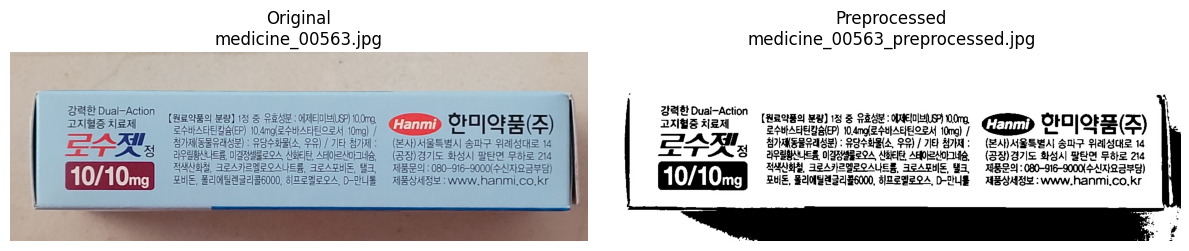

[입력 ] /content/data/원천데이터/TS1/result/medicine/images/medicine_00563.jpg
[출력 ] /content/data/preview/medicine_00563_preprocessed.jpg


In [ ]:
PREVIEW_DIR = Path("/content/data/preview")
PREVIEW_DIR.mkdir(parents=True, exist_ok=True)

# 하나 뽑아서 보기
def list_jpgs(root: Path):
    return [p for p in root.rglob("*.jpg") if p.suffix.lower() in IMG_EXTS]

def show_random_preprocess():
    # train/val/test 전체에서 무작위 1장
    all_imgs = list_jpgs(RAW_SPLIT_IMG_ROOT)
    if not all_imgs:
        raise FileNotFoundError(f"이미지를 찾을 수 없음: {RAW_SPLIT_IMG_ROOT}")

    img_path = random.choice(all_imgs)

    # 출력 경로
    out_path = PREVIEW_DIR / f"{img_path.stem}_preprocessed.jpg"

    # 전처리 실행 (저장까지 수행)
    _ = preprocess_image_pipeline(input_path=img_path, output_path=out_path)

    # 시각화: 원본(BGR→RGB), 전처리(단일채널→RGB 변환)
    orig = safe_imread(img_path)
    if orig is None:
        raise FileNotFoundError(f"이미지 로드 실패: {img_path}")
    orig_rgb = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)

    proc = cv2.imdecode(np.fromfile(str(out_path), dtype=np.uint8), cv2.IMREAD_UNCHANGED)
    if proc is None:
        raise FileNotFoundError(f"전처리 결과 로드 실패: {out_path}")
    if proc.ndim == 2:
        proc_rgb = cv2.cvtColor(proc, cv2.COLOR_GRAY2RGB)
    else:
        proc_rgb = cv2.cvtColor(proc, cv2.COLOR_BGR2RGB)

    # 플롯
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1); plt.imshow(orig_rgb); plt.title(f"Original\n{img_path.name}"); plt.axis("off")
    plt.subplot(1,2,2); plt.imshow(proc_rgb); plt.title(f"Preprocessed\n{out_path.name}"); plt.axis("off")
    plt.tight_layout()
    plt.show()

    print("[입력 ]", img_path)
    print("[출력 ]", out_path)

# 실행
show_random_preprocess()

### 미학습 PaddleOCR (추론만)

In [ ]:
import csv
import subprocess
from paddleocr import PaddleOCR, draw_ocr
from PIL import Image

/usr/local/lib/python3.11/dist-packages/paddle/fluid/framework.py:549: UserWarning: You are using GPU version Paddle, but your CUDA device is not set properly. CPU device will be used by default.
  warnings.warn(


In [ ]:
# GPU/CPU 자동 감지
def detect_gpu():
    try:
        output = subprocess.check_output("nvidia-smi", shell=True, stderr=subprocess.STDOUT)
        return True
    except subprocess.CalledProcessError:
        return False

USE_GPU = detect_gpu()
print(f"[INFO] GPU 사용 여부: {USE_GPU}")

[INFO] GPU 사용 여부: False


In [ ]:
# 폰트 다운로드 (한글 폰트)
!wget -q https://github.com/google/fonts/raw/main/ofl/nanumgothic/NanumGothic-Regular.ttf -O /content/NanumGothic.ttf
FONT_PATH = "/content/NanumGothic.ttf"

In [ ]:
ocr = PaddleOCR(
    use_angle_cls=True,
    lang='korean',
    rec=True,
    det=True,
    use_gpu=USE_GPU
)

download https://paddleocr.bj.bcebos.com/PP-OCRv3/multilingual/Multilingual_PP-OCRv3_det_infer.tar to /root/.paddleocr/whl/det/ml/Multilingual_PP-OCRv3_det_infer/Multilingual_PP-OCRv3_det_infer.tar


100%|██████████| 3.85M/3.85M [00:17<00:00, 217kiB/s] 


download https://paddleocr.bj.bcebos.com/PP-OCRv4/multilingual/korean_PP-OCRv4_rec_infer.tar to /root/.paddleocr/whl/rec/korean/korean_PP-OCRv4_rec_infer/korean_PP-OCRv4_rec_infer.tar


100%|██████████| 24.4M/24.4M [00:19<00:00, 1.25MiB/s]


download https://paddleocr.bj.bcebos.com/dygraph_v2.0/ch/ch_ppocr_mobile_v2.0_cls_infer.tar to /root/.paddleocr/whl/cls/ch_ppocr_mobile_v2.0_cls_infer/ch_ppocr_mobile_v2.0_cls_infer.tar


100%|██████████| 2.19M/2.19M [00:16<00:00, 129kiB/s]

[2025/08/13 10:37:46] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/ml/Multilingual_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/korean/korean_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, re

In [ ]:
def run_inference_and_visualize(img_path, output_dir):
    img_save_dir = Path(output_dir) / "images"
    csv_save_dir = Path(output_dir) / "csv"
    img_save_dir.mkdir(parents=True, exist_ok=True)
    csv_save_dir.mkdir(parents=True, exist_ok=True)

    # RAW에서 바로 읽기
    image = safe_imread(img_path)
    if image is None:
        raise FileNotFoundError(f"이미지 로드 실패: {img_path}")
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # PaddleOCR 추론
    result = ocr.ocr(str(img_path), cls=True)

    # 가드
    boxes, txts, scores = [], [], []
    if result and isinstance(result, list) and len(result)>0 and result[0]:
        for line in (result[0] or []):
            if not line or len(line)!=2:
                continue
            box, ts = line
            if ts is None or not isinstance(ts, (list, tuple)) or len(ts)!=2:
                continue
            txt, score = ts
            try:
                score = float(score)
            except Exception:
                score = 0.0
            txt = "" if txt is None else str(txt)
            # box 유효성
            if not box or any(not isinstance(pt,(list,tuple)) or len(pt)!=2 for pt in box):
                continue
            boxes.append(box); txts.append(txt); scores.append(score)

    # 시각화
    if len(boxes)>0:
        vis = draw_ocr(image_rgb, boxes, txts, scores, font_path=FONT_PATH)
        im_show = Image.fromarray(vis)
    else:
        im_show = Image.fromarray(image_rgb)

    stem = Path(img_path).stem
    save_img_path = img_save_dir / f"{stem}_ocr_result.jpg"
    save_csv_path = csv_save_dir / f"{stem}_ocr_result.csv"

    # 이미지 저장
    im_show.save(save_img_path)

    # CSV 저장 (빈 결과도 헤더는 씀)
    with open(save_csv_path, 'w', newline='', encoding='utf-8-sig') as f:
        w = csv.writer(f)
        w.writerow(["x1","y1","x2","y2","x3","y3","x4","y4","text","score"])
        for box, txt, score in zip(boxes, txts, scores):
            flat = []
            for pt in box:
                try:
                    x,y = float(pt[0]), float(pt[1])
                except Exception:
                    x,y = 0.0, 0.0
                flat += [x,y]
            if len(flat)!=8:
                flat = (flat + [0.0]*(8-len(flat)))[:8]
            w.writerow(flat + [txt, score])

    return save_img_path, save_csv_path

In [ ]:
val_dir = RAW_SPLIT_IMG_ROOT / "val"
output_dir = PRETRAINED_OUT_DIR

val_images = [p for p in val_dir.iterdir() if p.is_file() and p.suffix.lower() in IMG_EXTS]
for img_path in tqdm(val_images, desc="PaddleOCR Pretrained Inference", unit="img"):
    try:
        run_inference_and_visualize(img_path, output_dir)
    except Exception as e:
        print(f"[ERROR] {img_path.name} 처리 중 오류: {e}")

PaddleOCR Pretrained Inference:   0%|          | 0/38 [00:00<?, ?img/s]

[2025/08/13 10:38:15] ppocr DEBUG: dt_boxes num : 55, elapsed : 2.627047538757324
[2025/08/13 10:38:16] ppocr DEBUG: cls num  : 55, elapsed : 1.0271580219268799
[2025/08/13 10:38:43] ppocr DEBUG: rec_res num  : 55, elapsed : 27.26837682723999


PaddleOCR Pretrained Inference:   3%|▎         | 1/38 [00:32<19:45, 32.05s/img]

[2025/08/13 10:38:44] ppocr DEBUG: dt_boxes num : 62, elapsed : 0.6950201988220215
[2025/08/13 10:38:45] ppocr DEBUG: cls num  : 62, elapsed : 0.6190550327301025
[2025/08/13 10:39:16] ppocr DEBUG: rec_res num  : 62, elapsed : 30.791862726211548


PaddleOCR Pretrained Inference:   5%|▌         | 2/38 [01:04<19:24, 32.36s/img]

[2025/08/13 10:39:17] ppocr DEBUG: dt_boxes num : 6, elapsed : 1.5097072124481201
[2025/08/13 10:39:17] ppocr DEBUG: cls num  : 6, elapsed : 0.0574951171875
[2025/08/13 10:39:27] ppocr DEBUG: rec_res num  : 6, elapsed : 9.22353196144104


PaddleOCR Pretrained Inference:   8%|▊         | 3/38 [01:15<13:13, 22.68s/img]

[2025/08/13 10:39:30] ppocr DEBUG: dt_boxes num : 10, elapsed : 2.2599141597747803
[2025/08/13 10:39:31] ppocr DEBUG: cls num  : 10, elapsed : 0.6099238395690918
[2025/08/13 10:39:37] ppocr DEBUG: rec_res num  : 10, elapsed : 6.486932277679443


PaddleOCR Pretrained Inference:  11%|█         | 4/38 [01:26<10:05, 17.80s/img]

[2025/08/13 10:39:38] ppocr DEBUG: dt_boxes num : 37, elapsed : 0.6442708969116211
[2025/08/13 10:39:38] ppocr DEBUG: cls num  : 37, elapsed : 0.3434734344482422
[2025/08/13 10:39:56] ppocr DEBUG: rec_res num  : 37, elapsed : 17.549792766571045


PaddleOCR Pretrained Inference:  13%|█▎        | 5/38 [01:45<10:00, 18.20s/img]

[2025/08/13 10:39:58] ppocr DEBUG: dt_boxes num : 8, elapsed : 1.461756706237793
[2025/08/13 10:39:58] ppocr DEBUG: cls num  : 8, elapsed : 0.14292478561401367
[2025/08/13 10:40:04] ppocr DEBUG: rec_res num  : 8, elapsed : 5.822535514831543


PaddleOCR Pretrained Inference:  16%|█▌        | 6/38 [01:52<07:49, 14.69s/img]

[2025/08/13 10:40:05] ppocr DEBUG: dt_boxes num : 13, elapsed : 0.521007776260376
[2025/08/13 10:40:05] ppocr DEBUG: cls num  : 13, elapsed : 0.12239313125610352
[2025/08/13 10:40:11] ppocr DEBUG: rec_res num  : 13, elapsed : 5.958579063415527


PaddleOCR Pretrained Inference:  18%|█▊        | 7/38 [01:59<06:15, 12.10s/img]

[2025/08/13 10:40:11] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.4219324588775635
[2025/08/13 10:40:11] ppocr DEBUG: cls num  : 8, elapsed : 0.07747673988342285
[2025/08/13 10:40:18] ppocr DEBUG: rec_res num  : 8, elapsed : 6.068954706192017


PaddleOCR Pretrained Inference:  21%|██        | 8/38 [02:06<05:11, 10.40s/img]

[2025/08/13 10:40:18] ppocr DEBUG: dt_boxes num : 96, elapsed : 0.5442006587982178
[2025/08/13 10:40:19] ppocr DEBUG: cls num  : 96, elapsed : 0.9083070755004883
[2025/08/13 10:41:07] ppocr DEBUG: rec_res num  : 96, elapsed : 47.4232964515686


PaddleOCR Pretrained Inference:  24%|██▎       | 9/38 [02:55<10:55, 22.60s/img]

[2025/08/13 10:41:07] ppocr DEBUG: dt_boxes num : 72, elapsed : 0.323091983795166
[2025/08/13 10:41:08] ppocr DEBUG: cls num  : 72, elapsed : 0.6916224956512451
[2025/08/13 10:41:47] ppocr DEBUG: rec_res num  : 72, elapsed : 38.37838435173035


PaddleOCR Pretrained Inference:  26%|██▋       | 10/38 [03:35<13:01, 27.92s/img]

[2025/08/13 10:41:47] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.500474214553833
[2025/08/13 10:41:48] ppocr DEBUG: cls num  : 9, elapsed : 0.08391714096069336
[2025/08/13 10:41:53] ppocr DEBUG: rec_res num  : 9, elapsed : 4.996425151824951


PaddleOCR Pretrained Inference:  29%|██▉       | 11/38 [03:41<09:30, 21.14s/img]

[2025/08/13 10:41:54] ppocr DEBUG: dt_boxes num : 6, elapsed : 1.5568246841430664
[2025/08/13 10:41:54] ppocr DEBUG: cls num  : 6, elapsed : 0.09457159042358398
[2025/08/13 10:42:02] ppocr DEBUG: rec_res num  : 6, elapsed : 8.03010368347168


PaddleOCR Pretrained Inference:  32%|███▏      | 12/38 [03:51<07:41, 17.74s/img]

[2025/08/13 10:42:03] ppocr DEBUG: dt_boxes num : 26, elapsed : 0.5851030349731445
[2025/08/13 10:42:04] ppocr DEBUG: cls num  : 26, elapsed : 0.2702202796936035
[2025/08/13 10:42:17] ppocr DEBUG: rec_res num  : 26, elapsed : 13.714524984359741


PaddleOCR Pretrained Inference:  34%|███▍      | 13/38 [04:06<07:01, 16.87s/img]

[2025/08/13 10:42:18] ppocr DEBUG: dt_boxes num : 88, elapsed : 0.7068448066711426
[2025/08/13 10:42:19] ppocr DEBUG: cls num  : 88, elapsed : 0.8169956207275391
[2025/08/13 10:43:04] ppocr DEBUG: rec_res num  : 88, elapsed : 44.747007846832275


PaddleOCR Pretrained Inference:  37%|███▋      | 14/38 [04:53<10:22, 25.94s/img]

[2025/08/13 10:43:05] ppocr DEBUG: dt_boxes num : 10, elapsed : 0.47631168365478516
[2025/08/13 10:43:05] ppocr DEBUG: cls num  : 10, elapsed : 0.09369397163391113
[2025/08/13 10:43:11] ppocr DEBUG: rec_res num  : 10, elapsed : 5.582786560058594


PaddleOCR Pretrained Inference:  39%|███▉      | 15/38 [04:59<07:41, 20.06s/img]

[2025/08/13 10:43:11] ppocr DEBUG: dt_boxes num : 26, elapsed : 0.5288374423980713
[2025/08/13 10:43:12] ppocr DEBUG: cls num  : 26, elapsed : 0.4171452522277832
[2025/08/13 10:43:24] ppocr DEBUG: rec_res num  : 26, elapsed : 12.19611644744873


PaddleOCR Pretrained Inference:  42%|████▏     | 16/38 [05:13<06:38, 18.11s/img]

[2025/08/13 10:43:26] ppocr DEBUG: dt_boxes num : 19, elapsed : 1.3790748119354248
[2025/08/13 10:43:26] ppocr DEBUG: cls num  : 19, elapsed : 0.32376909255981445
[2025/08/13 10:43:35] ppocr DEBUG: rec_res num  : 19, elapsed : 9.012256145477295


PaddleOCR Pretrained Inference:  45%|████▍     | 17/38 [05:24<05:36, 16.01s/img]

[2025/08/13 10:43:36] ppocr DEBUG: dt_boxes num : 63, elapsed : 0.66963791847229
[2025/08/13 10:43:37] ppocr DEBUG: cls num  : 63, elapsed : 0.9700508117675781
[2025/08/13 10:44:10] ppocr DEBUG: rec_res num  : 63, elapsed : 32.725881814956665


PaddleOCR Pretrained Inference:  47%|████▋     | 18/38 [05:59<07:13, 21.66s/img]

[2025/08/13 10:44:11] ppocr DEBUG: dt_boxes num : 44, elapsed : 0.32285523414611816
[2025/08/13 10:44:11] ppocr DEBUG: cls num  : 44, elapsed : 0.4168064594268799
[2025/08/13 10:44:32] ppocr DEBUG: rec_res num  : 44, elapsed : 20.636910915374756


PaddleOCR Pretrained Inference:  50%|█████     | 19/38 [06:20<06:52, 21.69s/img]

[2025/08/13 10:44:33] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.5150907039642334
[2025/08/13 10:44:33] ppocr DEBUG: cls num  : 8, elapsed : 0.11277508735656738
[2025/08/13 10:44:39] ppocr DEBUG: rec_res num  : 8, elapsed : 6.299960613250732


PaddleOCR Pretrained Inference:  53%|█████▎    | 20/38 [06:27<05:11, 17.30s/img]

[2025/08/13 10:44:40] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.917607307434082
[2025/08/13 10:44:40] ppocr DEBUG: cls num  : 7, elapsed : 0.07557988166809082
[2025/08/13 10:44:46] ppocr DEBUG: rec_res num  : 7, elapsed : 5.478124618530273


PaddleOCR Pretrained Inference:  55%|█████▌    | 21/38 [06:34<04:00, 14.13s/img]

[2025/08/13 10:44:46] ppocr DEBUG: dt_boxes num : 48, elapsed : 0.40159082412719727
[2025/08/13 10:44:47] ppocr DEBUG: cls num  : 48, elapsed : 0.47337794303894043
[2025/08/13 10:45:12] ppocr DEBUG: rec_res num  : 48, elapsed : 25.009224891662598


PaddleOCR Pretrained Inference:  58%|█████▊    | 22/38 [07:00<04:43, 17.75s/img]

[2025/08/13 10:45:13] ppocr DEBUG: dt_boxes num : 8, elapsed : 1.0985126495361328
[2025/08/13 10:45:13] ppocr DEBUG: cls num  : 8, elapsed : 0.09285688400268555
[2025/08/13 10:45:17] ppocr DEBUG: rec_res num  : 8, elapsed : 3.833287000656128


PaddleOCR Pretrained Inference:  61%|██████    | 23/38 [07:06<03:29, 13.99s/img]

[2025/08/13 10:45:18] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.5635263919830322
[2025/08/13 10:45:18] ppocr DEBUG: cls num  : 6, elapsed : 0.09117007255554199
[2025/08/13 10:45:23] ppocr DEBUG: rec_res num  : 6, elapsed : 5.2152626514434814


PaddleOCR Pretrained Inference:  63%|██████▎   | 24/38 [07:12<02:42, 11.61s/img]

[2025/08/13 10:45:24] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.666064977645874
[2025/08/13 10:45:24] ppocr DEBUG: cls num  : 9, elapsed : 0.0847012996673584
[2025/08/13 10:45:29] ppocr DEBUG: rec_res num  : 9, elapsed : 4.355963706970215


PaddleOCR Pretrained Inference:  66%|██████▌   | 25/38 [07:17<02:06,  9.72s/img]

[2025/08/13 10:45:29] ppocr DEBUG: dt_boxes num : 8, elapsed : 0.4282214641571045
[2025/08/13 10:45:29] ppocr DEBUG: cls num  : 8, elapsed : 0.08098626136779785
[2025/08/13 10:45:34] ppocr DEBUG: rec_res num  : 8, elapsed : 5.05365252494812


PaddleOCR Pretrained Inference:  68%|██████▊   | 26/38 [07:23<01:42,  8.53s/img]

[2025/08/13 10:45:35] ppocr DEBUG: dt_boxes num : 24, elapsed : 0.45539355278015137
[2025/08/13 10:45:36] ppocr DEBUG: cls num  : 24, elapsed : 0.38004040718078613
[2025/08/13 10:45:47] ppocr DEBUG: rec_res num  : 24, elapsed : 11.504831552505493


PaddleOCR Pretrained Inference:  71%|███████   | 27/38 [07:36<01:48,  9.86s/img]

[2025/08/13 10:45:48] ppocr DEBUG: dt_boxes num : 57, elapsed : 0.6836063861846924
[2025/08/13 10:45:49] ppocr DEBUG: cls num  : 57, elapsed : 0.8779473304748535
[2025/08/13 10:46:21] ppocr DEBUG: rec_res num  : 57, elapsed : 31.580628156661987


PaddleOCR Pretrained Inference:  74%|███████▎  | 28/38 [08:10<02:50, 17.07s/img]

[2025/08/13 10:46:22] ppocr DEBUG: dt_boxes num : 44, elapsed : 0.4485752582550049
[2025/08/13 10:46:22] ppocr DEBUG: cls num  : 44, elapsed : 0.40557146072387695
[2025/08/13 10:46:47] ppocr DEBUG: rec_res num  : 44, elapsed : 24.880836486816406


PaddleOCR Pretrained Inference:  76%|███████▋  | 29/38 [08:36<02:57, 19.77s/img]

[2025/08/13 10:46:49] ppocr DEBUG: dt_boxes num : 8, elapsed : 1.179394245147705
[2025/08/13 10:46:49] ppocr DEBUG: cls num  : 8, elapsed : 0.07800960540771484
[2025/08/13 10:46:53] ppocr DEBUG: rec_res num  : 8, elapsed : 3.942272663116455


PaddleOCR Pretrained Inference:  79%|███████▉  | 30/38 [08:41<02:04, 15.53s/img]

[2025/08/13 10:46:53] ppocr DEBUG: dt_boxes num : 7, elapsed : 0.42064523696899414
[2025/08/13 10:46:54] ppocr DEBUG: cls num  : 7, elapsed : 0.06799626350402832
[2025/08/13 10:46:57] ppocr DEBUG: rec_res num  : 7, elapsed : 2.998527765274048


PaddleOCR Pretrained Inference:  82%|████████▏ | 31/38 [08:45<01:23, 11.97s/img]

[2025/08/13 10:46:57] ppocr DEBUG: dt_boxes num : 26, elapsed : 0.30295300483703613
[2025/08/13 10:46:57] ppocr DEBUG: cls num  : 26, elapsed : 0.26765918731689453
[2025/08/13 10:47:11] ppocr DEBUG: rec_res num  : 26, elapsed : 13.636349439620972


PaddleOCR Pretrained Inference:  84%|████████▍ | 32/38 [08:59<01:16, 12.73s/img]

[2025/08/13 10:47:12] ppocr DEBUG: dt_boxes num : 48, elapsed : 0.6521708965301514
[2025/08/13 10:47:12] ppocr DEBUG: cls num  : 48, elapsed : 0.47509074211120605
[2025/08/13 10:47:40] ppocr DEBUG: rec_res num  : 48, elapsed : 27.55329155921936


PaddleOCR Pretrained Inference:  87%|████████▋ | 33/38 [09:28<01:28, 17.62s/img]

[2025/08/13 10:47:41] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.8942198753356934
[2025/08/13 10:47:41] ppocr DEBUG: cls num  : 6, elapsed : 0.055103302001953125
[2025/08/13 10:47:47] ppocr DEBUG: rec_res num  : 6, elapsed : 5.452233791351318


PaddleOCR Pretrained Inference:  89%|████████▉ | 34/38 [09:35<00:57, 14.31s/img]

[2025/08/13 10:47:47] ppocr DEBUG: dt_boxes num : 21, elapsed : 0.5229744911193848
[2025/08/13 10:47:48] ppocr DEBUG: cls num  : 21, elapsed : 0.22110915184020996
[2025/08/13 10:47:57] ppocr DEBUG: rec_res num  : 21, elapsed : 8.896290302276611


PaddleOCR Pretrained Inference:  92%|█████████▏| 35/38 [09:45<00:38, 12.98s/img]

[2025/08/13 10:47:58] ppocr DEBUG: dt_boxes num : 84, elapsed : 0.7983126640319824
[2025/08/13 10:47:59] ppocr DEBUG: cls num  : 84, elapsed : 1.305938720703125
[2025/08/13 10:48:42] ppocr DEBUG: rec_res num  : 84, elapsed : 42.49416470527649


PaddleOCR Pretrained Inference:  95%|█████████▍| 36/38 [10:30<00:45, 22.75s/img]

[2025/08/13 10:48:43] ppocr DEBUG: dt_boxes num : 15, elapsed : 0.6584951877593994
[2025/08/13 10:48:43] ppocr DEBUG: cls num  : 15, elapsed : 0.2375657558441162
[2025/08/13 10:48:50] ppocr DEBUG: rec_res num  : 15, elapsed : 6.964382886886597


PaddleOCR Pretrained Inference:  97%|█████████▋| 37/38 [10:39<00:18, 18.37s/img]

[2025/08/13 10:48:51] ppocr DEBUG: dt_boxes num : 33, elapsed : 0.4957895278930664
[2025/08/13 10:48:51] ppocr DEBUG: cls num  : 33, elapsed : 0.3070080280303955
[2025/08/13 10:49:10] ppocr DEBUG: rec_res num  : 33, elapsed : 18.941070079803467


PaddleOCR Pretrained Inference: 100%|██████████| 38/38 [10:59<00:00, 17.35s/img]




---



### 미학습 에러 분석

In [ ]:
from pathlib import Path
import json, re, numpy as np, pandas as pd
from rapidfuzz.distance import Levenshtein

In [ ]:
CSV_DIR = Path("/content/pretrained_results/csv")
REPORT_DIR = Path("/content/pretrained_results/report")
REPORT_DIR.mkdir(parents=True, exist_ok=True)

SCORE_TH = 0.8

In [ ]:
rows = []
csv_files = sorted(CSV_DIR.glob("*.csv"))
if not csv_files:
    raise FileNotFoundError(f"예측 CSV가 없습니다: {CSV_DIR}")

for csvf in csv_files:
    df = pd.read_csv(csvf)
    # 좌표/텍스트/점수 컬럼 고정
    cols = ["x1","y1","x2","y2","x3","y3","x4","y4","text","score"]
    if not set(cols).issubset(df.columns):
        print(f"[WARN] 누락 컬럼으로 스킵: {csvf.name} -> {sorted(set(cols)-set(df.columns))}")
        continue

    df = df[cols].copy()
    df["image_id"] = csvf.stem.replace("_ocr_result","")

    # bbox 특성(대략치): 너비/높이/면적/종횡비
    xs = df[["x1","x2","x3","x4"]].to_numpy()
    ys = df[["y1","y2","y3","y4"]].to_numpy()
    w = xs.max(axis=1) - xs.min(axis=1)
    h = ys.max(axis=1) - ys.min(axis=1)
    area = w * h
    aspect = np.divide(w, np.maximum(h, 1))

    df["width_px"]  = w
    df["height_px"] = h
    df["area_px"]   = area
    df["aspect"]    = aspect
    df["text_len"]  = df["text"].astype(str).str.len()

    # 특수 패턴 플래그
    df["has_hyphen"] = df["text"].astype(str).str.contains(r"[-–—]", regex=True)
    df["has_symbol"] = df["text"].astype(str).str.contains(r"[^\w\s가-힣]", regex=True)

    rows.append(df)

all_df = pd.concat(rows, ignore_index=True) if rows else pd.DataFrame(columns=[
    "x1","y1","x2","y2","x3","y3","x4","y4","text","score","image_id",
    "width_px","height_px","area_px","aspect","text_len","has_hyphen","has_symbol"
])

# 저신뢰만 필터
low = all_df[all_df["score"] <= SCORE_TH].copy()

# 요약 1) 이미지별 저신뢰 개수
per_image = (low.groupby("image_id")
             .size()
             .reset_index(name="low_conf_cnt")
             .sort_values("low_conf_cnt", ascending=False))

# 요약 2) 패턴/크기별 통계
summary = {
    "total_preds": [len(all_df)],
    "low_conf_preds": [len(low)],
    "low_conf_rate(%)": [round(100*len(low)/max(len(all_df),1),2)],
    "median_height_low": [float(low["height_px"].median() if len(low) else 0)],
    "median_width_low":  [float(low["width_px"].median() if len(low) else 0)],
    "has_hyphen_rate_low(%)": [round(100*low["has_hyphen"].mean(),2) if len(low) else 0],
    "has_symbol_rate_low(%)": [round(100*low["has_symbol"].mean(),2) if len(low) else 0],
    "text_len_median_low": [float(low["text_len"].median() if len(low) else 0)],
}
summary_df = pd.DataFrame(summary)

# 저장
low_path = REPORT_DIR / "low_confidence_details.csv"
per_image_path = REPORT_DIR / "low_confidence_per_image.csv"
summary_path = REPORT_DIR / "low_confidence_summary.csv"

low.to_csv(low_path, index=False, encoding="utf-8-sig")
per_image.to_csv(per_image_path, index=False, encoding="utf-8-sig")
summary_df.to_csv(summary_path, index=False, encoding="utf-8-sig")

print("[저장] 자세한 목록:", low_path)
print("[저장] 이미지별 개수:", per_image_path)
print("[저장] 요약 통계:", summary_path)

# 화면 출력
print("\n=== 요약 ===")
print(summary_df.to_string(index=False))

print("\n=== 상위 문제 이미지 10개 ===")
print(per_image.head(10).to_string(index=False))

print("\n=== 예시(점수 낮은 상위 10개) ===")
print(low.sort_values("score")
        .head(10)[["image_id","text","score","width_px","height_px","has_hyphen","has_symbol","text_len"]]
        .to_string(index=False))

[저장] 자세한 목록: /content/pretrained_results/report/low_confidence_details.csv
[저장] 이미지별 개수: /content/pretrained_results/report/low_confidence_per_image.csv
[저장] 요약 통계: /content/pretrained_results/report/low_confidence_summary.csv

=== 요약 ===
 total_preds  low_conf_preds  low_conf_rate(%)  median_height_low  median_width_low  has_hyphen_rate_low(%)  has_symbol_rate_low(%)  text_len_median_low
        1024             119             11.62               78.0             200.0                    6.72                   19.33                  3.0

=== 상위 문제 이미지 10개 ===
      image_id  low_conf_cnt
medicine_00559            14
medicine_00616            12
medicine_00369            10
medicine_00282             9
medicine_00322             9
medicine_00392             8
medicine_00279             6
medicine_00182             6
medicine_00519             5
medicine_00236             5

=== 예시(점수 낮은 상위 10개) ===
      image_id    text    score  width_px  height_px  has_hyphen  has_symbol  text_len


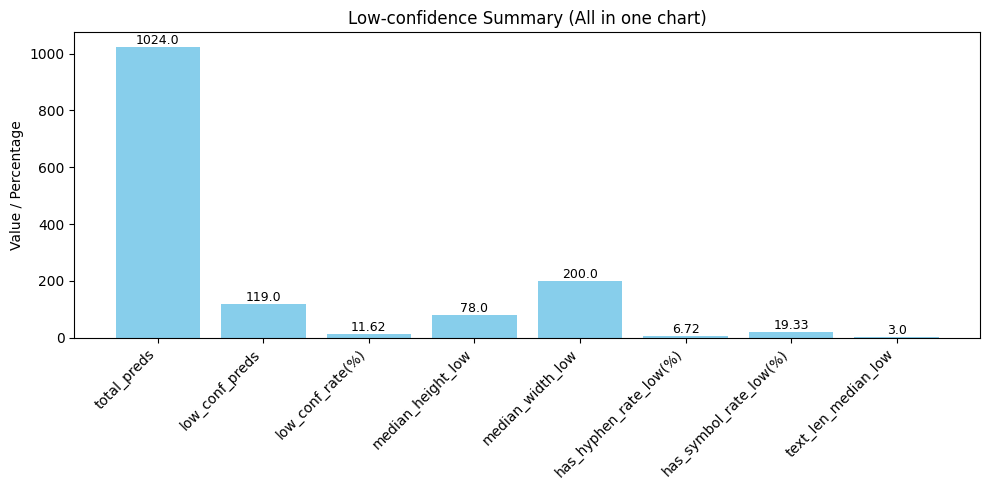

In [ ]:
row = summary_df.iloc[0].to_dict()

# 키: 값 형태로 변환 (dict -> list)
labels = list(row.keys())
values = list(row.values())

# 그래프 그리기
plt.figure(figsize=(10,5))
bars = plt.bar(labels, values, color='skyblue')

# 값 표시
for b, v in zip(bars, values):
    plt.text(b.get_x() + b.get_width()/2, v, f"{v}",
             ha='center', va='bottom', fontsize=9)

plt.xticks(rotation=45, ha='right')
plt.title("Low-confidence Summary (All in one chart)")
plt.ylabel("Value / Percentage")
plt.tight_layout()
plt.show()



---



### 에러 상세분석

#### 1. 전체 예측 대비 저신뢰 비율
- 전체 예측 수: 1,024

- 저신뢰 예측 수: 119

- 저신뢰 비율: 11.62%
→ 전체 중 약 10% 이상이 confidence threshold 이하로 판정됨.

#### 2. 저신뢰 박스 특성
- 세로길이 중앙값: 78 px

- 가로길이 중앙값: 200 px
→ 높이가 낮고 가로로 긴 박스가 많은 편 (라벨·성분표·긴 단어 가능성 높음)

- 하이픈 포함 비율: 6.72%

- 특수문자 포함 비율: 19.33%
→ 특수문자(%, 숫자+기호 등) 포함된 경우가 5건 중 1건꼴로 나타남

- 텍스트 길이 중앙값: 3글자
→ 짧은 단어(2~4글자)가 다수

#### 3. 문제 발생 상위 이미지
- medicine_00559 : 14건 → 가장 많은 저신뢰 탐지 (특정 제품에 글씨체/배경이 어려운 경우 가능성 높음)

- medicine_00616 : 12건

- medicine_00369, medicine_00282 : 9~10건
→ 특정 제품·라벨 영역에서 집중적으로 성능 저하 발생



#### 4. 저신뢰 예시 분석 (상위 10개)
    

- 의미 없는 음절 조합 → 글씨 왜곡·노이즈 가능성
- 언더바 포함 → 특수문자 처리 취약
- 한글+한자 혼합 → 다국어 폰트 학습 부족
- 짧은 단어, 폰트 영향 가능
- 4글자, 일부 합성어·폰트 왜곡 가능
- 매우 짧은 단어, 배경 대비 문제 가능
- 숫자 단독 → 폰트·배경 혼동 가능
- 영문+숫자+한글 혼합 → 멀티언어 인식 취약
- 짧고 발음상 낯선 조합
- 1글자 단독, 배경 대비 취약

#### 5. 원인 요약
1. 짧은 단어 / 한 글자 인식 약함 → 배경과 글자 색 대비 부족 시 confidence 급락

2. 다국어·혼합 문자 처리 취약 → 한글+한자, 숫자+영문+한글 조합

3. 특수문자 포함 처리 미흡 → 언더바, 기호 포함 시 오류

4. 폰트/배경 난이도 → 특정 제품 라벨, 작은 글씨, 가로로 긴 영역

5. 특정 이미지군 집중 문제 → 일부 제품(예: medicine_00559)에서 다수 발생



---



### 학습된 PaddleOCR(FT)
작은 글씨/기호 조합 문제가 가장많음

- 인식기(REC) 위주 파인튜닝
- 사전(딕셔너리) 보강 + 인식 전용 파인튜닝



In [ ]:
IMG_ROOT = Path("/content/data/원천데이터/TS1")          # images:   TS1/{train,val}
ANN_ROOT = Path("/content/data/라벨링데이터/TL1")        # labels:   TL1/{train,val}
MANIFEST_DIR = Path("/content/manifests")                # split_{train,val}.csv (optional)

OUT_ROOT = Path("/content/recdata")
(OUT_ROOT/"train/imgs").mkdir(parents=True, exist_ok=True)
(OUT_ROOT/"val/imgs").mkdir(parents=True, exist_ok=True)

In [ ]:
# ---------------- I/O helpers ----------------
def safe_imread(p):
    p = str(p)
    data = np.fromfile(p, dtype=np.uint8)
    return cv2.imdecode(data, cv2.IMREAD_COLOR)

def safe_imsave(p, img):
    p = Path(p); p.parent.mkdir(parents=True, exist_ok=True)
    ok, buf = cv2.imencode(".jpg", img, [int(cv2.IMWRITE_JPEG_QUALITY), 95])
    if ok: buf.tofile(str(p))

In [ ]:
# ---------------- Geometry helpers ----------------
def clip_box(x1, y1, x2, y2, w, h):
    x1 = max(0, min(int(x1), w-1))
    y1 = max(0, min(int(y1), h-1))
    x2 = max(0, min(int(x2), w-1))
    y2 = max(0, min(int(y2), h-1))
    if x2 <= x1: x2 = min(w-1, x1+1)
    if y2 <= y1: y2 = min(h-1, y1+1)
    return x1, y1, x2, y2

def _aabb_from_points(pts):
    xs = [float(p[0]) for p in pts]; ys = [float(p[1]) for p in pts]
    return [min(xs), min(ys), max(xs), max(ys)]

def aabb_from_mixed(bbox):
    """
    bbox → [x1,y1,x2,y2] 변환.
    지원:
      - dict {x,y,width,height}
      - [x,y,w,h]
      - [[x,y], ...]  (polygon/quad)
      - [ {x,y,width,height}, ... ]  (여러 조각 → 합집합)
    """
    def _is_num(x):
        try:
            float(x); return True
        except Exception:
            return False

    def _xywh(x,y,w,h): return [float(x), float(y), float(x)+float(w), float(y)+float(h)]
    def _from_points(pts):
        xs = [float(p[0]) for p in pts]; ys = [float(p[1]) for p in pts]
        return [min(xs), min(ys), max(xs), max(ys)]
    def _union(boxes):
        xs1=[b[0] for b in boxes]; ys1=[b[1] for b in boxes]
        xs2=[b[2] for b in boxes]; ys2=[b[3] for b in boxes]
        return [min(xs1), min(ys1), max(xs2), max(ys2)]

    # dict
    if isinstance(bbox, dict):
        x=bbox.get("x", bbox.get("left")); y=bbox.get("y", bbox.get("top"))
        w=bbox.get("width", bbox.get("w")); h=bbox.get("height", bbox.get("h"))
        if all(_is_num(v) for v in [x,y,w,h]):
            return _xywh(x,y,w,h)

    # list
    if isinstance(bbox, list):
        # [x,y,w,h]
        if len(bbox)==4 and all(_is_num(v) for v in bbox):
            x,y,w,h = bbox; return _xywh(x,y,w,h)
        # [[x,y], ...]
        if len(bbox)>=2 and all(isinstance(p,(list,tuple)) and len(p)==2 for p in bbox):
            return _from_points(bbox)
        # [ {x,y,width,height}, ... ]  (조각 리스트 → 합집합)
        if len(bbox)>=1 and all(isinstance(it, dict) for it in bbox):
            boxes=[]
            for it in bbox:
                x=it.get("x"); y=it.get("y"); w=it.get("width"); h=it.get("height")
                if None not in (x,y,w,h):
                    boxes.append(_xywh(x,y,w,h))
            if boxes:
                return _union(boxes)

    return None

In [ ]:
# ---------------- JSON parser (your schema) ----------------
def parse_gt(json_path: Path):
    """
    네 JSON 구조 전용 파서:
      annotations[*].bbox     : [{'id','x','y','width','height'}, ...]
      annotations[*].polygons : [{'id','points':[[x,y],...], 'text':"...", ...}, ...]
    - text는 polygon['text']
    - bbox는 polygon points로 AABB 계산(정밀), 실패 시 동일 id의 xywh 사용
    return: [{'text': str, 'bbox': [x1,y1,x2,y2]}, ...]
    """
    out = []
    try:
        data = json.loads(json_path.read_text(encoding="utf-8"))
    except Exception:
        return out

    anns = data.get("annotations", [])
    if not isinstance(anns, list) or not anns:
        return out

    for ann in anns:
        # id → xyxy bbox map (from xywh)
        bbox_by_id = {}
        for b in ann.get("bbox", []) or []:
            try:
                _id = b.get("id")
                x, y = float(b.get("x")), float(b.get("y"))
                w, h = float(b.get("width")), float(b.get("height"))
                bbox_by_id[_id] = [x, y, x + w, y + h]
            except Exception:
                continue

        # polygons: use points → AABB (preferred), else fall back to bbox_by_id
        for poly in ann.get("polygons", []) or []:
            _id  = poly.get("id")
            text = poly.get("text", "")
            text = "" if text is None else str(text).replace("\t"," ").replace("\n"," ").strip()
            if text == "":
                continue

            aabb = None
            pts = poly.get("points")
            if isinstance(pts, list) and len(pts) >= 2 and all(isinstance(p,(list,tuple)) and len(p)==2 for p in pts):
                try:
                    aabb = _aabb_from_points(pts)
                except Exception:
                    aabb = None
            if aabb is None:
                aabb = bbox_by_id.get(_id)

            if aabb is not None:
                out.append({"text": text, "bbox": aabb})

    return out

In [ ]:
# ---------------- Pairs & dataset builders ----------------
def build_pairs_from_manifest(split):
    mf = MANIFEST_DIR / f"split_{split}.csv"
    pairs=[]
    if mf.exists():
        import pandas as pd
        df = pd.read_csv(mf)
        for _, r in df.iterrows():
            img_path = IMG_ROOT/split/Path(r["image_rel"]).name
            ann_path = ANN_ROOT/split/Path(r["ann_rel"]).name
            if img_path.exists() and ann_path.exists():
                pairs.append((img_path, ann_path))
    else:
        # fallback: 디렉터리 스캔 (stem 일치)
        for img in (IMG_ROOT/split).glob("*.jpg"):
            stem = img.stem
            cand = list((ANN_ROOT/split).glob(stem + ".json"))
            if cand:
                pairs.append((img, cand[0]))
    return pairs

def make_rec_split(split, pad_ratio=0.03, min_px=8):
    out_dir = OUT_ROOT/split/"imgs"
    list_path = OUT_ROOT/f"{split}.txt"
    pairs = build_pairs_from_manifest(split)

    n_total = 0
    with open(list_path, "w", encoding="utf-8") as fw:
        for img_path, ann_path in tqdm(pairs, desc=f"Make Rec {split}", unit="img"):
            img = safe_imread(img_path)
            if img is None:
                continue
            H, W = img.shape[:2]
            gts = parse_gt(ann_path)

            for k, it in enumerate(gts):
                x1, y1, x2, y2 = it["bbox"]
                # padding
                pad = int(pad_ratio * max(x2-x1, y2-y1))
                x1p, y1p, x2p, y2p = clip_box(x1-pad, y1-pad, x2+pad, y2+pad, W, H)
                crop = img[y1p:y2p, x1p:x2p]
                if crop.size == 0:
                    continue
                # too small → skip
                if (y2p - y1p) < min_px or (x2p - x1p) < min_px:
                    continue

                out_name = f"{img_path.stem}_{k:04d}.jpg"
                out_path = out_dir / out_name
                safe_imsave(out_path, crop)

                # PaddleOCR Rec format: <abs_path>\t<label>
                fw.write(f"{str(out_path)}\t{it['text']}\n")
                n_total += 1

    return n_total, list_path

In [ ]:
# ---------------- Run (train / val) ----------------
train_cnt, train_txt = make_rec_split("train", pad_ratio=0.03, min_px=8)
val_cnt,   val_txt   = make_rec_split("val",   pad_ratio=0.03, min_px=8)

print(f"[DONE] train crops: {train_cnt} → {train_txt}")
print(f"[DONE] val crops:   {val_cnt} → {val_txt}")

Make Rec val: 100%|██████████| 38/38 [00:04<00:00,  8.59img/s]

[DONE] train crops: 11752 → /content/recdata/train.txt
[DONE] val crops:   1361 → /content/recdata/val.txt


#### 문자집합(사전) 만들가
- train/val 라벨에 실제로 등장하는 문자만 모아 커스텀 charset을 만듭니다.
(숫자·기호·한글·괄호·%·℃ 등 포함)

In [ ]:
train_txt = Path("/content/recdata/train.txt")
val_txt   = Path("/content/recdata/val.txt")
charset_path = Path("/content/recdata/charset.txt")

def harvest_chars(list_file: Path):
    chars = set()
    with open(list_file, encoding="utf-8") as f:
        for line in f:
            try:
                _, label = line.rstrip("\n").split("\t", 1)
            except ValueError:
                continue
            # 공백은 PaddleOCR 옵션으로 다룰 수 있으니 일단 그대로 둠
            for ch in label:
                chars.add(ch)
    return chars

chars = harvest_chars(train_txt) | harvest_chars(val_txt)

# 자주 쓰이는 기호들 보강 (누락 시 추가)
extra = list("()-[]{}%℃°/_.·+×=~:,;!?'\"\\|*@#&")
for ch in extra:
    chars.add(ch)

# 줄바꿈 없이 "문자 1개 = 1라인"
with open(charset_path, "w", encoding="utf-8") as fw:
    for ch in sorted(chars):
        fw.write(ch + "\n")

print("[OK] charset size:", sum(1 for _ in open(charset_path, encoding="utf-8")))
print("[PATH]", charset_path)

[OK] charset size: 755
[PATH] /content/recdata/charset.txt


#### 학습/파인튜닝 paddle.git 가져오기

In [ ]:
!git clone https://github.com/PaddlePaddle/PaddleOCR.git
%cd /content/PaddleOCR

Cloning into 'PaddleOCR'...
remote: Enumerating objects: 269522, done.
remote: Counting objects: 100% (713/713), done.
remote: Compressing objects: 100% (165/165), done.
remote: Total 269522 (delta 622), reused 548 (delta 548), pack-reused 268809 (from 2)
Receiving objects: 100% (269522/269522), 1.42 GiB | 21.09 MiB/s, done.
Resolving deltas: 100% (212752/212752), done.
Updating files: 100% (1903/1903), done.
/content/PaddleOCR


In [ ]:
# 충돌 항목 제거한 임시 요구사항 파일 생성
!grep -nE "numpy|opencv|paddlepaddle|paddleocr|shapely" requirements.txt || true
!awk 'BEGIN{IGNORECASE=1} !/numpy|opencv|paddlepaddle|paddleocr|shapely/' requirements.txt > req_sanitized.txt

# 우리가 만든 constraints(예: numpy==1.26.4)로 고정 설치
!pip install -q -c /content/constraints.txt --upgrade-strategy only-if-needed -r req_sanitized.txt

1:shapely
6:numpy
8:opencv-python
9:opencv-contrib-python
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 MB 11.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
paddleocr 2.7.0.3 requires pdf2docx, which is not installed.
paddleocr 2.7.0.3 requires premailer, which is not installed.
paddleocr 2.7.0.3 requires PyMuPDF<1.21.0, which is not installed.
paddleocr 2.7.0.3 requires python-docx, which is not installed.
paddleocr 2.7.0.3 requires visualdl, which is not installed.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [ ]:
%cd /content/PaddleOCR

/content/PaddleOCR


#### YAML 파일 생성
- CRNN+CTC 구성
- 한국어 커스텀 charset
- 배치/해상도는 T4 기준

In [ ]:
train_txt = Path("/content/recdata/train.txt")
val_txt   = Path("/content/recdata/val.txt")
charset   = Path("/content/recdata/charset.txt")

assert train_txt.exists(), f"missing: {train_txt}"
assert val_txt.exists(),   f"missing: {val_txt}"
assert charset.exists(),   f"missing: {charset}"

print("[OK] files:")
print(" -", train_txt, f"(lines={sum(1 for _ in open(train_txt, encoding='utf-8'))})")
print(" -", val_txt,   f"(lines={sum(1 for _ in open(val_txt,   encoding='utf-8'))})")
print(" -", charset,   f"(lines={sum(1 for _ in open(charset,   encoding='utf-8'))})")

[OK] files:
 - /content/recdata/train.txt (lines=11752)
 - /content/recdata/val.txt (lines=1361)
 - /content/recdata/charset.txt (lines=755)


In [ ]:
# ===== 2) 파인튜닝용 설정파일 작성 (CRNN + CTC, 한국어 커스텀 charset) =====
cfg = r"""
Global:
  debug: false
  use_gpu: True
  epoch_num: 60
  save_epoch_step: 5
  print_batch_step: 50
  save_model_dir: /content/output/rec_korean_crnn_ctc
  eval_batch_step: [0, 2000]
  cal_metric_during_train: True
  character_dict_path: /content/recdata/charset.txt
  max_text_length: 40
  character_type: ch
  use_space_char: True
  pretrained_model: ""   # 사전학습 weight 있으면 경로로 대체
  checkpoints: ""        # 이어서 학습할 체크포인트 경로 (없으면 공란)

Optimizer:
  name: Adam
  beta1: 0.9
  beta2: 0.999
  lr:
    name: Cosine
    learning_rate: 0.0005
  regularizer:
    name: L2
    factor: 0.00001

Architecture:
  model_type: rec
  algorithm: CRNN
  Transform:
    name: STN_ON
    tps: False
  Backbone:
    name: ResNet
    layers: 34
  Neck:
    name: SequenceEncoder
    encoder_type: rnn
    hidden_size: 256
  Head:
    name: CTCHead
    fc_decay: 0.00001

Loss:
  name: CTCLoss

PostProcess:
  name: CTCLabelDecode
  character_dict_path: /content/recdata/charset.txt
  use_space_char: True

Metric:
  name: RecMetric
  main_indicator: acc
  is_filter: false
  gt_matched: True

Train:
  dataset:
    name: SimpleDataSet
    data_dir: /
    label_file_list:
      - /content/recdata/train.txt
    transforms:
      - DecodeImage:
          img_mode: BGR
          channel_first: False
      - RecAug:
      - CTCLabelEncode:
          character_dict_path: /content/recdata/charset.txt
          use_space_char: True
      - RecResizeImg:
          image_shape: [3, 32, 320]   # (C,H,W); H=32 고정
      - NormalizeImage:
          mean: [127.5, 127.5, 127.5]
          std: [127.5, 127.5, 127.5]
          scale: 1./255.
      - ToCHWImage:
      - KeepKeys:
          keep_keys: ["image", "label", "length"]
  loader:
    shuffle: True
    batch_size_per_card: 128   # 메모리 여유 있으면 192/256로 올려도 OK
    drop_last: False
    num_workers: 2

Eval:
  dataset:
    name: SimpleDataSet
    data_dir: /
    label_file_list:
      - /content/recdata/val.txt
    transforms:
      - DecodeImage:
          img_mode: BGR
          channel_first: False
      - CTCLabelEncode:
          character_dict_path: /content/recdata/charset.txt
          use_space_char: True
      - RecResizeImg:
          image_shape: [3, 32, 320]
      - NormalizeImage:
          mean: [127.5, 127.5, 127.5]
          std: [127.5, 127.5, 127.5]
          scale: 1./255.
      - ToCHWImage:
      - KeepKeys:
          keep_keys: ["image", "label", "length"]
  loader:
    shuffle: False
    drop_last: False
    batch_size_per_card: 256
    num_workers: 2
"""
open("rec_korean_crnn_ctc.yml","w", encoding="utf-8").write(cfg)
print("[OK] wrote ./rec_korean_crnn_ctc.yml")


[OK] wrote ./rec_korean_crnn_ctc.yml


#### 학습 실행

In [ ]:
!python3 tools/train.py \
  -c rec_korean_crnn_ctc.yml \
  -o Global.save_model_dir=/content/output/rec_korean_crnn_ctc

/usr/local/lib/python3.11/dist-packages/paddle/fluid/framework.py:549: UserWarning: You are using GPU version Paddle, but your CUDA device is not set properly. CPU device will be used by default.
  warnings.warn(
[2025/08/13 11:13:23] ppocr WARNING: Skipping import of the encryption module.
E0813 11:13:23.750654 18035 place.cc:332] Cannot use GPU because there is no GPU detected on your machine.


In [ ]:
# 베스트 체크포인트로 지정 (실제 생성된 디렉터리명 확인)
BEST="/content/output/rec_korean_crnn_ctc/best_accuracy"

!python3 tools/infer_rec.py \
  -c /content/rec_korean_crnn_ctc.yml \
  -o Global.checkpoints=$BEST \
  -o Predicts.restore_infer_model=False \
  -o Global.infer_img=/content/recdata/val/imgs

[2025/08/13 05:34:35] ppocr WARNING: Skipping import of the encryption module.
W0813 05:34:37.415527 10391 gpu_resources.cc:119] Please NOTE: device: 0, GPU Compute Capability: 7.5, Driver API Version: 12.4, Runtime API Version: 11.7
W0813 05:34:37.416496 10391 gpu_resources.cc:149] device: 0, cuDNN Version: 90.2.
Traceback (most recent call last):
  File "/content/PaddleOCR/tools/export_model.py", line 37, in <module>
    main()
  File "/content/PaddleOCR/tools/export_model.py", line 33, in main
    export(config)
  File "/content/PaddleOCR/ppocr/utils/export_model.py", line 500, in export
    load_model(config, model, model_type=config["Architecture"]["model_type"])
  File "/content/PaddleOCR/ppocr/utils/save_load.py", line 113, in load_model
    assert os.path.exists(
           ^^^^^^^^^^^^^^^
AssertionError: The ./output/rec_kor_ft/best_accuracy.pdparams does not exists!


### CER/WER 평가 (val.txt 기준)

In [ ]:
# 베스트 체크포인트 자동탐색 & export (Colab에서 !/%%bash 대신 파이썬으로 안전하게 실행)
import os, subprocess, shlex, sys
from pathlib import Path

SAVE_ROOT = Path("/content/output/rec_korean_crnn_ctc")
BEST = None

best_dir = SAVE_ROOT / "best_accuracy"
if best_dir.exists():
    BEST = str(best_dir)
else:
    # epoch_* 중 가장 큰 번호
    epochs = sorted([p for p in SAVE_ROOT.glob("epoch_*") if p.is_dir()],
                    key=lambda p: int(p.name.split("_")[-1]) if p.name.split("_")[-1].isdigit() else -1)
    if epochs:
        BEST = str(epochs[-1])

if BEST is None:
    raise FileNotFoundError(f"체크포인트를 찾을 수 없습니다: {SAVE_ROOT}")

print("[BEST]", BEST)

# export_model.py 실행
%cd /content/PaddleOCR
cmd = f"python3 tools/export_model.py -c rec_korean_crnn_ctc.yml -o Global.checkpoints='{BEST}' Global.save_inference_dir='{SAVE_ROOT}/inference_rec'"
print("[RUN]", cmd)
ret = subprocess.run(shlex.split(cmd), check=False)
if ret.returncode != 0:
    sys.exit(ret.returncode)
print(f"[OK] exported to {SAVE_ROOT}/inference_rec")


[Pretrained] total=1110, low=162 (14.59%)
[Mixed-FT ] total=1498, low=199 (13.28%)
==> 개선: +1.31 pp


In [ ]:
# Rec-only 추론 → CER/WER 평가
%cd /content/PaddleOCR

from pathlib import Path
import pandas as pd
from tqdm import tqdm
from rapidfuzz.distance import Levenshtein
from paddleocr import PaddleOCR

SAVE_ROOT = Path("/content/output/rec_korean_crnn_ctc")
INFER_DIR = SAVE_ROOT / "inference_rec"
VAL_LIST  = Path("/content/recdata/val.txt")
OUT_DIR   = SAVE_ROOT / "eval"; OUT_DIR.mkdir(parents=True, exist_ok=True)
OUT_CSV   = OUT_DIR / "rec_eval_val.csv"

# rec-only OCR 로드 (export된 모델 사용)
ocr = PaddleOCR(det=False, rec=True, cls=False, use_gpu=True, lang='korean',
                rec_model_dir=str(INFER_DIR))

def cer(pred: str, gt: str) -> float:
    return Levenshtein.distance(pred or "", gt or "") / max(1, len(gt or ""))

def wer(pred: str, gt: str) -> float:
    gt_words = (gt or "").split()
    pr_words = (pred or "").split()
    return Levenshtein.distance(" ".join(pr_words), " ".join(gt_words)) / max(1, len(gt_words))

pairs = []
with open(VAL_LIST, encoding="utf-8") as f:
    lines = [ln.rstrip("\n") for ln in f if "\t" in ln]

for ln in tqdm(lines, desc="Infer(rec) on VAL"):
    img_path, gt = ln.split("\t", 1)
    try:
        out = ocr.ocr(img_path, det=False, cls=False)
        # out 예: [[('텍스트', score)]]
        if isinstance(out, list) and len(out)>0:
            cand = out[0]
            if isinstance(cand, list) and len(cand)>0 and isinstance(cand[0], (list, tuple)):
                pred = str(cand[0][0])
                score = float(cand[0][1])
            elif isinstance(cand, (list,tuple)) and len(cand)>=2:
                pred = str(cand[0]); score = float(cand[1])
            else:
                pred, score = "", float("nan")
        else:
            pred, score = "", float("nan")
    except Exception:
        pred, score = "", float("nan")

    pairs.append({"img": img_path, "gt": gt, "pred": pred, "score": score,
                  "cer": cer(pred, gt), "wer": wer(pred, gt)})

df = pd.DataFrame(pairs)
df.to_csv(OUT_CSV, index=False, encoding="utf-8-sig")
print(f"[SAVED] {OUT_CSV} (rows={len(df)})")
print("CER mean:", round(float(df['cer'].mean()), 4))
print("WER mean:", round(float(df['wer'].mean()), 4))


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

SAVE_ROOT = Path("/content/output/rec_korean_crnn_ctc")
OUT_DIR   = SAVE_ROOT / "eval"
OUT_CSV   = OUT_DIR / "rec_eval_val.csv"

df = pd.read_csv(OUT_CSV)

# (A) CER/WER 막대그래프
cer_mean = df["cer"].mean()
wer_mean = df["wer"].mean()

plt.figure(figsize=(5,4))
bars = plt.bar(["CER", "WER"], [cer_mean, wer_mean])
for b,v in zip(bars, [cer_mean, wer_mean]):
    plt.text(b.get_x()+b.get_width()/2, v, f"{v:.3f}", ha="center", va="bottom")
plt.title("Recognition Error — Mean CER/WER (val)")
plt.ylabel("error")
plt.ylim(0, max(cer_mean, wer_mean)*1.3)
plt.tight_layout()
plot1 = OUT_DIR / "cer_wer_bar.png"
plt.savefig(plot1, dpi=150)
plt.show()
print("[Saved]", plot1)

# (B) 길이별 CER 중앙값
df["gt_len"] = df["gt"].astype(str).str.len()
bins = [0,2,4,6,8,12,20,40]
cats = pd.cut(df["gt_len"], bins=bins, right=False)
cer_med = df.groupby(cats)["cer"].median().reset_index()

plt.figure(figsize=(7,4))
plt.plot(cer_med["gt_len"].astype(str), cer_med["cer"], marker="o")
plt.title("Median CER by GT Length (val)")
plt.xlabel("GT length bins")
plt.ylabel("Median CER")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plot2 = OUT_DIR / "cer_by_len.png"
plt.savefig(plot2, dpi=150)
plt.show()
print("[Saved]", plot2)
